Add what stuff we have to do with the data (if anything is left):
1. Add missing values
2. Change column names
3. Add dummy columns
4. Multiply columns with a constant
5. Change categorical data class names (e.g. Male Female to M F)

**Check accuracy on original data**

## Dummy Columns:
1. Oligo-Bertrand Symptoms: Positive, Negative, Skewed, Unknown
2. Anti Raster Probability: ([Mutation Count] - [Tumor Purity]) * [TMB] / 1000
3. OLPG (Rate): Random number from 0.000 to 1.000

## Constant multiplication:
1. Multiply TMB with 106
2. Multiply Tumor Purity with 3.47
3. Subtract 206 from Sample Coverage
4. Multiply No. of samples with 4
5. Multiply DNA Input with 0.39

## Modify rows:
1. Randomly change year in rows of study id from 2020 to 2015, 2016, 2017, 2018, 2019
2. Change study id rows to some format of POMS_year
3. Put some random variation in No. of samples

## Change column names:
1. [Cancer Type] to [Type of Cancer]
2. [Cancer Type Detailed] to [Verbose Type of Cancer]
3. [Diagnosis Age] to [Patient Age]
4. [Sex] to [Gender]
5. [Smoke Status] to [Alcohol/Tobacco Consumption]

## Remove some data:
Randomly remove 3% to 5% data in columns:
1. [Type of Cancer]
2. [Sample Coverage]
3. [Patient Age]
4. [DNA Input]
5. [Mutation Count]
6. [No. of samples]
7. [Sample Type]
8. [Alcohol/Tobacco Consumption]
9. [TMB]
10. [Tumor Purity] 

In [1]:
import numpy as np
import pandas as pd

In [28]:
df = pd.read_csv('https://raw.githubusercontent.com/SpookyWooky5/datawiz2k21/main/pan_origimed_2020_clinical_data.tsv', sep='\t')

In [3]:
df.head()

,Study ID,Patient ID,Sample ID,Tumor Stage,Cancer Type,Cancer Type Detailed,Sample Coverage,Diagnosis Age,DNA Input,Mutation Count,Number of Samples Per Patient,Sample Type,Sex,Smoke Status,Specimen Preservation Type,Specimen Type,TMB (nonsynonymous),Treatment,Tumor Purity
0,pan_origimed_2020,Patient0001,P-0001,IV,Colorectal Carcinoma,Colorectal Adenocarcinoma,1171.0,67,4776,9.0,1,Primary,Female,Unknown,FFPE,Surgery,0.333333,Other_Treatments,45
1,pan_origimed_2020,Patient0002,P-0002,II,Colorectal Carcinoma,Colorectal Adenocarcinoma,476.0,75,3876,9.0,1,Primary,Male,Unknown,FFPE,Surgery,0.300000,Treatment-naive,40
2,pan_origimed_2020,Patient0003,P-0003,III,Colorectal Carcinoma,Colorectal Adenocarcinoma,1277.0,45,9720,13.0,1,Primary,Female,Unknown,FFPE,Surgery,0.500000,Treatment-naive,45
3,pan_origimed_2020,Patient0004,P-0004,III,Colorectal Carcinoma,Colorectal Adenocarcinoma,1667.0,70,33840,213.0,1,Primary,Male,Unknown,FFPE,Surgery,7.266667,Treatment-naive,60
4,pan_origimed_2020,Patient0005,P-0005,I,Liver Hepatocellular Carcinoma,Hepatocellular Carcinoma,935.0,53,2412,5.0,1,Primary,Male,Unknown,FFPE,Surgery,0.166667,Treatment-naive,85


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Study ID                       10194 non-null  object 
 1   Patient ID                     10194 non-null  object 
 2   Sample ID                      10194 non-null  object 
 3   Tumor Stage                    10194 non-null  object 
 4   Cancer Type                    10194 non-null  object 
 5   Cancer Type Detailed           10194 non-null  object 
 6   Sample Coverage                10194 non-null  float64
 7   Diagnosis Age                  10194 non-null  int64  
 8   DNA Input                      10194 non-null  int64  
 9   Mutation Count                 9799 non-null   float64
 10  Number of Samples Per Patient  10194 non-null  int64  
 11  Sample Type                    10194 non-null  object 
 12  Sex                            10194 non-null 

In [5]:
df.describe()

,Sample Coverage,Diagnosis Age,DNA Input,Mutation Count,Number of Samples Per Patient,TMB (nonsynonymous),Tumor Purity
count,10194.000000,10194.000000,10194.000000,9799.000000,10194.0,10194.000000,10194.000000
mean,1222.189784,56.190210,4012.856190,9.574038,1.0,0.309610,52.555032
std,368.148055,13.259325,4255.615534,20.611201,0.0,0.695799,23.340739
min,300.000000,1.000000,50.000000,1.000000,1.0,0.000000,10.000000
25%,992.000000,49.000000,1194.000000,3.000000,1.0,0.100000,30.000000
50%,1202.000000,58.000000,3096.000000,6.000000,1.0,0.200000,50.000000
75%,1428.000000,65.000000,4968.000000,9.000000,1.0,0.300000,70.000000
max,6010.000000,96.000000,43680.000000,520.000000,1.0,17.433333,99.000000


In [6]:
for col in df.columns:
    if len(df[col].unique()) < 2:
        print(col)

print("the above are useless columns we can drop")

Study ID
Number of Samples Per Patient
Specimen Preservation Type
the above are useless columns we can drop


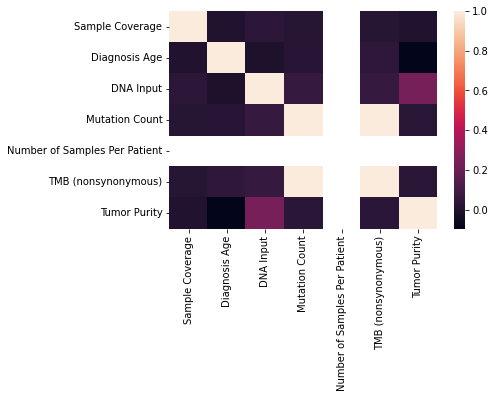

In [7]:
import seaborn as sns
sns.heatmap(df.corr())

In [ ]:
df['Smoke Status'].unique()

array(['Unknown', 'Nonsmoker', 'Smoker'], dtype=object)

## Some Basic data cleaning and encoding on the raw data

In [29]:
cleandf = df.copy(deep=True)

for col in df.columns:
    if len(df[col].unique()) < 2:
        cleandf.drop(col, axis=1, inplace=True)
        print(col)

cleandf.drop(['Patient ID', 'Sample ID'], axis=1, inplace=True)

Study ID
Number of Samples Per Patient
Specimen Preservation Type


In [30]:
cX = cleandf.drop(['Tumor Stage', 'Cancer Type Detailed', 'Treatment'], axis=1)
cy = cleandf['Tumor Stage']

In [10]:
from sklearn.preprocessing import LabelEncoder 

In [11]:
for col in [i for i in cX.columns if cX.dtypes[i] == 'O']:
    le = LabelEncoder().fit(cX[col])
    cX[col] = le.transform(cX[col])

le_cy = LabelEncoder().fit(cy)
cy = le_cy.transform(cy)

In [12]:
cX['Mutation Count'].fillna(cX['Mutation Count'].mean(), inplace=True)

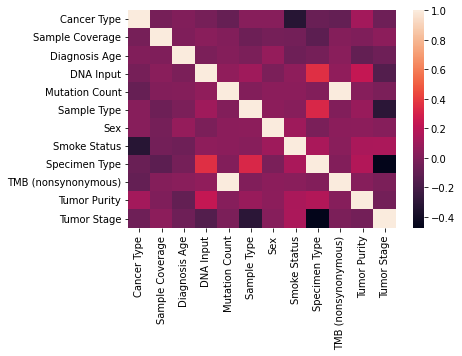

In [13]:
sns.heatmap(cX.merge(pd.Series(cy).rename('Tumor Stage'), left_index=True, right_index=True).corr())

In [14]:
from sklearn.model_selection import train_test_split

cX_train, cX_test, cy_train, cy_test = train_test_split(cX, cy, test_size=0.2, random_state=42)

In [15]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [16]:
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(cX_train, cy_train)

DecisionTreeClassifier(max_depth=4)

In [17]:
clf.score(cX_test, cy_test)

0.46199117214320745

In [18]:
reg = DecisionTreeRegressor(max_depth=4)
reg.fit(cX_train, cy_train)

DecisionTreeRegressor(max_depth=4)

In [19]:
reg.score(cX_test, cy_test)

0.3474592357790077

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard'
)

In [21]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(cX_train, cy_train)
    cy_pred = clf.predict(cX_test)
    print(clf.__class__.__name__, accuracy_score(cy_test, cy_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression 0.3379107405590976
RandomForestClassifier 0.4835703776360961
SVC 0.35605689063266305


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


VotingClassifier 0.39627268268759197


In [22]:
cX

,Cancer Type,Sample Coverage,Diagnosis Age,DNA Input,Mutation Count,Sample Type,Sex,Smoke Status,Specimen Type,TMB (nonsynonymous),Tumor Purity
0,4,1171.0,67,4776,9.0,1,0,2,1,0.333333,45
1,4,476.0,75,3876,9.0,1,1,2,1,0.300000,40
2,4,1277.0,45,9720,13.0,1,0,2,1,0.500000,45
3,4,1667.0,70,33840,213.0,1,1,2,1,7.266667,60
4,13,935.0,53,2412,5.0,1,1,2,1,0.166667,85
...,...,...,...,...,...,...,...,...,...,...,...
10189,8,879.0,55,2376,9.0,1,0,2,1,0.300000,60
10190,6,1098.0,57,2196,6.0,1,1,2,1,0.200000,40
10191,6,1131.0,48,966,1.0,1,1,2,1,0.033333,20
10192,8,1146.0,66,2448,2.0,1,1,2,1,0.066667,20


## Dummy Data Here

In [31]:
cleandf = cleandf.rename(columns = {'Cancer Type' : 'Type of Cancer', 'Cancer Type Detailed': 'Verbose Type of Cancer', 'Diagnosis Age': 'Patient Age', 'Sex': 'Gender', 'Smoke Status': 'Alcohol/Tobacco Consumption'})

In [32]:
cleandf['TMB (nonsynonymous)'] = 106*cleandf['TMB (nonsynonymous)']
cleandf['Tumor Purity'] = 3.47*cleandf['Tumor Purity']
cleandf['Sample Coverage'] = 206*cleandf['Sample Coverage']
cleandf['DNA Input'] = 0.39*cleandf['DNA Input']
cleandf

,Tumor Stage,Type of Cancer,Verbose Type of Cancer,Sample Coverage,Patient Age,DNA Input,Mutation Count,Sample Type,Gender,Alcohol/Tobacco Consumption,Specimen Type,TMB (nonsynonymous),Treatment,Tumor Purity
0,IV,Colorectal Carcinoma,Colorectal Adenocarcinoma,241226.0,67,1862.64,9.0,Primary,Female,Unknown,Surgery,35.333333,Other_Treatments,156.15
1,II,Colorectal Carcinoma,Colorectal Adenocarcinoma,98056.0,75,1511.64,9.0,Primary,Male,Unknown,Surgery,31.800000,Treatment-naive,138.80
2,III,Colorectal Carcinoma,Colorectal Adenocarcinoma,263062.0,45,3790.80,13.0,Primary,Female,Unknown,Surgery,53.000000,Treatment-naive,156.15
3,III,Colorectal Carcinoma,Colorectal Adenocarcinoma,343402.0,70,13197.60,213.0,Primary,Male,Unknown,Surgery,770.266667,Treatment-naive,208.20
4,I,Liver Hepatocellular Carcinoma,Hepatocellular Carcinoma,192610.0,53,940.68,5.0,Primary,Male,Unknown,Surgery,17.666667,Treatment-naive,294.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10189,III,Gastric Cancer,Gastric Adenocarcinoma,181074.0,55,926.64,9.0,Primary,Female,Unknown,Surgery,31.800000,Chemotherapy,208.20
10190,II,Extrahepatic Cholangiocarcinoma,Extrahepatic Cholangiocarcinoma,226188.0,57,856.44,6.0,Primary,Male,Unknown,Surgery,21.200000,Treatment-naive,138.80
10191,II,Extrahepatic Cholangiocarcinoma,Extrahepatic Cholangiocarcinoma,232986.0,48,376.74,1.0,Primary,Male,Unknown,Surgery,3.533333,Treatment-naive,69.40
10192,III,Gastric Cancer,Gastric Adenocarcinoma,236076.0,66,954.72,2.0,Primary,Male,Unknown,Surgery,7.066667,Unknown,69.40


In [33]:
cleandf = cleandf.sample(frac = 0.965)
cleandf

,Tumor Stage,Type of Cancer,Verbose Type of Cancer,Sample Coverage,Patient Age,DNA Input,Mutation Count,Sample Type,Gender,Alcohol/Tobacco Consumption,Specimen Type,TMB (nonsynonymous),Treatment,Tumor Purity
4314,I,Non Small Cell Lung Cancer,Lung Squamous Cell Carcinoma,345256.0,77,931.32,21.0,Primary,Male,Smoker,Surgery,70.666667,Treatment-naive,312.30
6958,I,Pancreatic Cancer,Pancreatic Adenocarcinoma,288812.0,60,893.88,8.0,Primary,Female,Unknown,Surgery,28.266667,Treatment-naive,208.20
6379,IV,Kidney Renal Cell Carcinoma,Renal Clear Cell Carcinoma,206824.0,40,842.40,5.0,Primary,Male,Unknown,Surgery,17.666667,Treatment-naive,277.60
2326,II,Intrahepatic Cholangiocarcinoma,Intrahepatic Cholangiocarcinoma,146260.0,64,1820.52,6.0,Primary,Female,Unknown,Surgery,17.666667,Treatment-naive,242.90
6610,IV,Esophageal Carcinoma,Esophageal Squamous Cell Carcinoma,483482.0,51,165.75,9.0,Metastasis,Male,Unknown,Biopsy/Paracentesis,31.800000,Radiation_Therapy;Targeted_Therapy;Chemotherapy,329.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,Unknown,Gastric Cancer,Gastric Adenocarcinoma,100940.0,56,376.74,7.0,Primary,Female,Unknown,Biopsy/Paracentesis,24.733333,Treatment-naive,69.40
3740,III,Gastric Cancer,Gastric Adenocarcinoma,222068.0,54,547.56,4.0,Primary,Male,Unknown,Surgery,14.133333,Treatment-naive,173.50
1588,III-IV,Non Small Cell Lung Cancer,Lung Adenocarcinoma,251320.0,70,400.14,6.0,Primary,Female,Nonsmoker,Biopsy/Paracentesis,21.200000,Unknown,242.90
8151,Unknown,Liver Hepatocellular Carcinoma,Liver Hepatocellular Carcinoma,338252.0,67,227.37,7.0,Primary,Male,Unknown,Biopsy/Paracentesis,21.200000,Unknown,242.90


In [35]:
import random
ls = []
for i in range(9837):
  ls.append(round(random.random(), 3))
cleandf['OLPG Rate'] = ls
cleandf

,Tumor Stage,Type of Cancer,Verbose Type of Cancer,Sample Coverage,Patient Age,DNA Input,Mutation Count,Sample Type,Gender,Alcohol/Tobacco Consumption,Specimen Type,TMB (nonsynonymous),Treatment,Tumor Purity,OLPG Rate
4314,I,Non Small Cell Lung Cancer,Lung Squamous Cell Carcinoma,345256.0,77,931.32,21.0,Primary,Male,Smoker,Surgery,70.666667,Treatment-naive,312.30,0.441
6958,I,Pancreatic Cancer,Pancreatic Adenocarcinoma,288812.0,60,893.88,8.0,Primary,Female,Unknown,Surgery,28.266667,Treatment-naive,208.20,0.078
6379,IV,Kidney Renal Cell Carcinoma,Renal Clear Cell Carcinoma,206824.0,40,842.40,5.0,Primary,Male,Unknown,Surgery,17.666667,Treatment-naive,277.60,0.980
2326,II,Intrahepatic Cholangiocarcinoma,Intrahepatic Cholangiocarcinoma,146260.0,64,1820.52,6.0,Primary,Female,Unknown,Surgery,17.666667,Treatment-naive,242.90,0.413
6610,IV,Esophageal Carcinoma,Esophageal Squamous Cell Carcinoma,483482.0,51,165.75,9.0,Metastasis,Male,Unknown,Biopsy/Paracentesis,31.800000,Radiation_Therapy;Targeted_Therapy;Chemotherapy,329.65,0.710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,Unknown,Gastric Cancer,Gastric Adenocarcinoma,100940.0,56,376.74,7.0,Primary,Female,Unknown,Biopsy/Paracentesis,24.733333,Treatment-naive,69.40,0.292
3740,III,Gastric Cancer,Gastric Adenocarcinoma,222068.0,54,547.56,4.0,Primary,Male,Unknown,Surgery,14.133333,Treatment-naive,173.50,0.972
1588,III-IV,Non Small Cell Lung Cancer,Lung Adenocarcinoma,251320.0,70,400.14,6.0,Primary,Female,Nonsmoker,Biopsy/Paracentesis,21.200000,Unknown,242.90,0.117
8151,Unknown,Liver Hepatocellular Carcinoma,Liver Hepatocellular Carcinoma,338252.0,67,227.37,7.0,Primary,Male,Unknown,Biopsy/Paracentesis,21.200000,Unknown,242.90,0.440


In [38]:
cleandf['Mutation Count'] = cleandf['Mutation Count'].fillna(cleandf['Mutation Count'].mean())

In [40]:
cleandf['Anti Raster Probability'] = cleandf['TMB (nonsynonymous)'].multiply(cleandf['Mutation Count'].sub(cleandf['Tumor Purity']))
cleandf['Anti Raster Probability'] = cleandf['Anti Raster Probability']*0.001
cleandf

,Tumor Stage,Type of Cancer,Verbose Type of Cancer,Sample Coverage,Patient Age,DNA Input,Mutation Count,Sample Type,Gender,Alcohol/Tobacco Consumption,Specimen Type,TMB (nonsynonymous),Treatment,Tumor Purity,OLPG Rate,Anti Raster Probability
4314,I,Non Small Cell Lung Cancer,Lung Squamous Cell Carcinoma,345256.0,77,931.32,21.0,Primary,Male,Smoker,Surgery,70.666667,Treatment-naive,312.30,0.441,-20.585200
6958,I,Pancreatic Cancer,Pancreatic Adenocarcinoma,288812.0,60,893.88,8.0,Primary,Female,Unknown,Surgery,28.266667,Treatment-naive,208.20,0.078,-5.658987
6379,IV,Kidney Renal Cell Carcinoma,Renal Clear Cell Carcinoma,206824.0,40,842.40,5.0,Primary,Male,Unknown,Surgery,17.666667,Treatment-naive,277.60,0.980,-4.815933
2326,II,Intrahepatic Cholangiocarcinoma,Intrahepatic Cholangiocarcinoma,146260.0,64,1820.52,6.0,Primary,Female,Unknown,Surgery,17.666667,Treatment-naive,242.90,0.413,-4.185233
6610,IV,Esophageal Carcinoma,Esophageal Squamous Cell Carcinoma,483482.0,51,165.75,9.0,Metastasis,Male,Unknown,Biopsy/Paracentesis,31.800000,Radiation_Therapy;Targeted_Therapy;Chemotherapy,329.65,0.710,-10.196670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,Unknown,Gastric Cancer,Gastric Adenocarcinoma,100940.0,56,376.74,7.0,Primary,Female,Unknown,Biopsy/Paracentesis,24.733333,Treatment-naive,69.40,0.292,-1.543360
3740,III,Gastric Cancer,Gastric Adenocarcinoma,222068.0,54,547.56,4.0,Primary,Male,Unknown,Surgery,14.133333,Treatment-naive,173.50,0.972,-2.395600
1588,III-IV,Non Small Cell Lung Cancer,Lung Adenocarcinoma,251320.0,70,400.14,6.0,Primary,Female,Nonsmoker,Biopsy/Paracentesis,21.200000,Unknown,242.90,0.117,-5.022280
8151,Unknown,Liver Hepatocellular Carcinoma,Liver Hepatocellular Carcinoma,338252.0,67,227.37,7.0,Primary,Male,Unknown,Biopsy/Paracentesis,21.200000,Unknown,242.90,0.440,-5.001080


In [41]:
ls = []
for i in range(9837):
  ls.append(random.choice(['Positive', 'Negative', 'Skewed', 'Unknown']))
cleandf['Oligo-Bertrand Symptoms'] = ls
cleandf

,Tumor Stage,Type of Cancer,Verbose Type of Cancer,Sample Coverage,Patient Age,DNA Input,Mutation Count,Sample Type,Gender,Alcohol/Tobacco Consumption,Specimen Type,TMB (nonsynonymous),Treatment,Tumor Purity,OLPG Rate,Anti Raster Probability,Oligo-Bertrand Symptoms
4314,I,Non Small Cell Lung Cancer,Lung Squamous Cell Carcinoma,345256.0,77,931.32,21.0,Primary,Male,Smoker,Surgery,70.666667,Treatment-naive,312.30,0.441,-20.585200,Positive
6958,I,Pancreatic Cancer,Pancreatic Adenocarcinoma,288812.0,60,893.88,8.0,Primary,Female,Unknown,Surgery,28.266667,Treatment-naive,208.20,0.078,-5.658987,Unknown
6379,IV,Kidney Renal Cell Carcinoma,Renal Clear Cell Carcinoma,206824.0,40,842.40,5.0,Primary,Male,Unknown,Surgery,17.666667,Treatment-naive,277.60,0.980,-4.815933,Skewed
2326,II,Intrahepatic Cholangiocarcinoma,Intrahepatic Cholangiocarcinoma,146260.0,64,1820.52,6.0,Primary,Female,Unknown,Surgery,17.666667,Treatment-naive,242.90,0.413,-4.185233,Unknown
6610,IV,Esophageal Carcinoma,Esophageal Squamous Cell Carcinoma,483482.0,51,165.75,9.0,Metastasis,Male,Unknown,Biopsy/Paracentesis,31.800000,Radiation_Therapy;Targeted_Therapy;Chemotherapy,329.65,0.710,-10.196670,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,Unknown,Gastric Cancer,Gastric Adenocarcinoma,100940.0,56,376.74,7.0,Primary,Female,Unknown,Biopsy/Paracentesis,24.733333,Treatment-naive,69.40,0.292,-1.543360,Unknown
3740,III,Gastric Cancer,Gastric Adenocarcinoma,222068.0,54,547.56,4.0,Primary,Male,Unknown,Surgery,14.133333,Treatment-naive,173.50,0.972,-2.395600,Negative
1588,III-IV,Non Small Cell Lung Cancer,Lung Adenocarcinoma,251320.0,70,400.14,6.0,Primary,Female,Nonsmoker,Biopsy/Paracentesis,21.200000,Unknown,242.90,0.117,-5.022280,Unknown
8151,Unknown,Liver Hepatocellular Carcinoma,Liver Hepatocellular Carcinoma,338252.0,67,227.37,7.0,Primary,Male,Unknown,Biopsy/Paracentesis,21.200000,Unknown,242.90,0.440,-5.001080,Negative


In [42]:
ls = []
for i in range(9837):
  ls.append(random.randint(1,10))
cleandf['No. of Samples'] = ls
cleandf

,Tumor Stage,Type of Cancer,Verbose Type of Cancer,Sample Coverage,Patient Age,DNA Input,Mutation Count,Sample Type,Gender,Alcohol/Tobacco Consumption,Specimen Type,TMB (nonsynonymous),Treatment,Tumor Purity,OLPG Rate,Anti Raster Probability,Oligo-Bertrand Symptoms,No. of Samples
4314,I,Non Small Cell Lung Cancer,Lung Squamous Cell Carcinoma,345256.0,77,931.32,21.0,Primary,Male,Smoker,Surgery,70.666667,Treatment-naive,312.30,0.441,-20.585200,Positive,6
6958,I,Pancreatic Cancer,Pancreatic Adenocarcinoma,288812.0,60,893.88,8.0,Primary,Female,Unknown,Surgery,28.266667,Treatment-naive,208.20,0.078,-5.658987,Unknown,9
6379,IV,Kidney Renal Cell Carcinoma,Renal Clear Cell Carcinoma,206824.0,40,842.40,5.0,Primary,Male,Unknown,Surgery,17.666667,Treatment-naive,277.60,0.980,-4.815933,Skewed,10
2326,II,Intrahepatic Cholangiocarcinoma,Intrahepatic Cholangiocarcinoma,146260.0,64,1820.52,6.0,Primary,Female,Unknown,Surgery,17.666667,Treatment-naive,242.90,0.413,-4.185233,Unknown,9
6610,IV,Esophageal Carcinoma,Esophageal Squamous Cell Carcinoma,483482.0,51,165.75,9.0,Metastasis,Male,Unknown,Biopsy/Paracentesis,31.800000,Radiation_Therapy;Targeted_Therapy;Chemotherapy,329.65,0.710,-10.196670,Negative,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,Unknown,Gastric Cancer,Gastric Adenocarcinoma,100940.0,56,376.74,7.0,Primary,Female,Unknown,Biopsy/Paracentesis,24.733333,Treatment-naive,69.40,0.292,-1.543360,Unknown,1
3740,III,Gastric Cancer,Gastric Adenocarcinoma,222068.0,54,547.56,4.0,Primary,Male,Unknown,Surgery,14.133333,Treatment-naive,173.50,0.972,-2.395600,Negative,2
1588,III-IV,Non Small Cell Lung Cancer,Lung Adenocarcinoma,251320.0,70,400.14,6.0,Primary,Female,Nonsmoker,Biopsy/Paracentesis,21.200000,Unknown,242.90,0.117,-5.022280,Unknown,2
8151,Unknown,Liver Hepatocellular Carcinoma,Liver Hepatocellular Carcinoma,338252.0,67,227.37,7.0,Primary,Male,Unknown,Biopsy/Paracentesis,21.200000,Unknown,242.90,0.440,-5.001080,Negative,6


In [43]:
cleandf.to_csv('Final.csv')


In [44]:
from google.colab import files
files.download('Final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Raw Data Here

In [ ]:
import numpy as np
import pandas as pd

raw = pd.read_csv('https://raw.githubusercontent.com/SpookyWooky5/datawiz2k21/main/pan_origimed_2020_clinical_data.tsv', sep='\t')

In [ ]:
from sklearn.preprocessing import LabelEncoder 
cX = raw.drop(['Tumor Stage', 'Cancer Type Detailed', 'Treatment'], axis=1)
cy = raw['Tumor Stage']
for col in [i for i in cX.columns if cX.dtypes[i] == 'O']:
    le = LabelEncoder().fit(cX[col])
    cX[col] = le.transform(cX[col])

le_cy = LabelEncoder().fit(cy)
cy = le_cy.transform(cy)

In [ ]:
from sklearn.model_selection import train_test_split
cX['Mutation Count'].fillna(cX['Mutation Count'].mean(), inplace=True)

cX_train, cX_test, cy_train, cy_test = train_test_split(cX, cy, test_size=0.2, random_state=101)

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(cX_train, cy_train)

LinearRegression()

In [ ]:
op = pd.DataFrame(lm.coef_, cX.columns, columns = ['Coefficients'])

In [ ]:
op
cy

array([6, 3, 4, ..., 3, 4, 4])

In [ ]:
pred = lm.predict(cX_test)
pred

array([3.74352704, 3.55656159, 3.8152193 , ..., 6.05031773, 3.77429646,
       3.74451562])

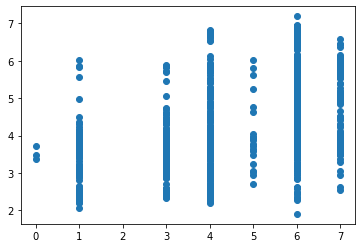

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(cy_test, pred)

In [ ]:
from sklearn import metrics

print(np.sqrt(metrics.mean_squared_error(cy_test, pred)))


1.651580829474431
